In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.spatial import distance

In [162]:
def load_initial(name):
    n_nodes = int(''.join(i for i in name if i.isdigit()))
    nodes = np.loadtxt(f"TSP/{name}.tsp.txt", skiprows = 6, max_rows = n_nodes)
    opt_tour = np.loadtxt(f"TSP/{name}.opt.tour.txt", skiprows = 5, max_rows = n_nodes)

    d_nodes = {}
    for node in nodes: 
        d_nodes[node[0]] = (node[1], node[2])

    return d_nodes, opt_tour

def plotnodes(nodes): 
    plt.figure(figsize = (9,9))

    for node, coordinates in nodes.items():
        plt.plot(coordinates[0], coordinates[1], 'ro')
        plt.annotate(int(node), (coordinates[0], coordinates[1]))

def plotedges(d_nodes, tour): 
    for i, node in enumerate(tour):
        if i >= len(tour) - 1:
            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[0]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[0]][1]

        else:  
            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[i+1]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[i+1]][1]

        x_coords = [x1,x2]
        y_coords = [y1,y2]

        plt.plot(x_coords, y_coords, color = 'grey')

def tour_length(d_nodes, tour):
    total_length_manual = 0

    for i, node in enumerate(tour):
        if i >= len(tour) - 1:
            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[0]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[0]][1]

        else:  
            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[i+1]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[i+1]][1]
       
        length_manual = np.sqrt((x1 - x2)**2 + (y1-y2)**2)
        
        total_length_manual += length_manual
    return total_length_manual

length = 429.98331198338406


<Figure size 1080x648 with 0 Axes>

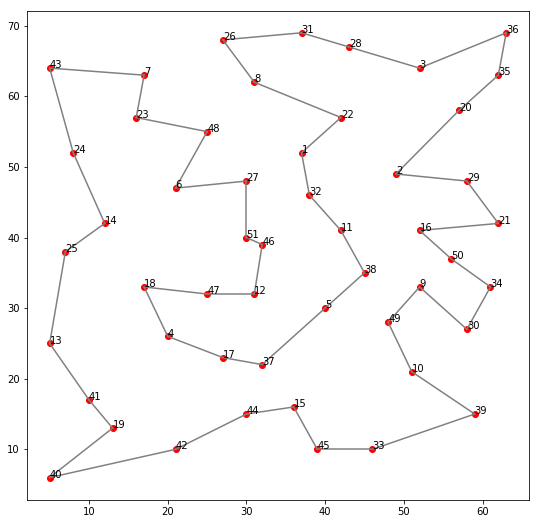

In [169]:
initial = load_initial("eil51")
plt.figure(figsize = (15,9))
plotnodes(initial[0])
plotedges(initial[0], initial[1])
print('length = ' + str(tour_length(initial[0], initial[1])))

In [90]:
def make_d_nodes(nodes): 
    d_nodes = {}

    for node in nodes:
        d_nodes[node[0]] = (node[1], node[2])

    return d_nodes

def make_tour_edges(tour): 
    tour_edges = []

    for i, node in enumerate(tour):
        if i < len(tour) - 1: 
            tour_edges.append([node, tour[i+1]])
        else:
            tour_edges.append([node, tour[0]])
    
    return tour_edges

def make_distance_matrix(d_nodes):
    n_nodes = len(d_nodes)
    distance_matrix = np.zeros((n_nodes,n_nodes))
    
    for node1 in range(n_nodes):
        for node2 in range(n_nodes):
            x1 = d_nodes[node1+1][0]
            x2 = d_nodes[node2+1][0]
            y1 = d_nodes[node1+1][1]
            y2 = d_nodes[node2+1][1]

            distance_matrix[node1, node2] = np.sqrt((x1 - x2)**2 + (y1-y2)**2)
    
    return distance_matrix
    
def comp_length_from_matrix(tour, distance_matrix):
    tour_edges = make_tour_edges(tour)
    total_distance = 0

    for edge in tour_edges: 
        total_distance += distance_matrix[int((edge[0] - 1)), int((edge[1] - 1))]
        
    return total_distance

def make_random_route(n_nodes):
    l_nodes = np.arange(1,n_nodes+1)
    return list(np.random.permutation(l_nodes))

<Figure size 1080x648 with 0 Axes>

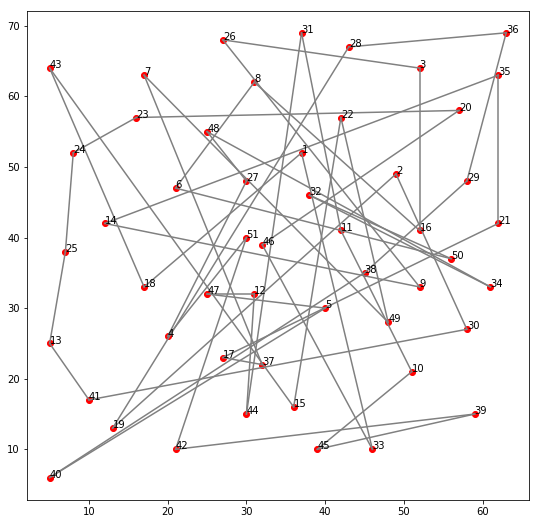

Length of tour = 1535.308474752656


In [91]:
distance_matrixeil51 = make_distance_matrix(initial[0])

random_route = make_random_route(51)

plt.figure(figsize = (15,9))
plotnodes(initial[0])
plotedges(initial[0], random_route)
plt.show()

print(f'Length of tour = {comp_length_from_matrix(random_route, distance_matrixeil51)}')

tour = np.arange(1, 6)

In [87]:
def lin2opt(initial_tour): 
    new_tour = np.copy(initial_tour)
    
    # apply lin 2 opt to tour
    n_nodes = len(new_tour)
    rand_node1 = np.random.randint(1, n_nodes+1)
    rand_node2 = np.random.randint(1, n_nodes+1)

    i_rand_node1 = np.argwhere(new_tour == rand_node1)[0][0]
    i_rand_node2 = np.argwhere(new_tour == rand_node2)[0][0]

    subtour = new_tour[min(i_rand_node1, i_rand_node2) + 1 : max(i_rand_node1, i_rand_node2)]
    flipped_subtour = np.flip(subtour)

    new_tour[min(i_rand_node1, i_rand_node2) + 1 : max(i_rand_node1, i_rand_node2)] = flipped_subtour
    return new_tour

In [92]:
def simulated_annealing(nodes, initial_tour, markov_chains, markov_length, initial_temp, cool_rate):
    tour = initial_tour
    temp = initial_temp

    distance_matrix = make_distance_matrix(nodes)

    # for plotting the costs per iteration
    costs = []

    for i in range(markov_chains):
        print('\r', f"{i} out of {markov_chains}", end='')

        for _ in range(markov_length):
            costs.append(comp_length_from_matrix(tour, distance_matrix))
            new_tour = lin2opt(tour)
            accept_prob = math.exp(min(709, -(comp_length_from_matrix(new_tour, distance_matrix) - costs[-1])/temp))

            if accept_prob >= 1 or np.random.rand() <= accept_prob:
                tour = new_tour

        temp *= cool_rate

    plt.plot(range(len(costs)), costs)
    plt.show()

    return tour

 199 out of 200

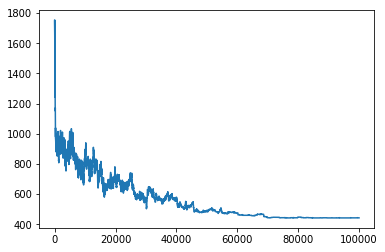

Length of found route: 442.53926643229715


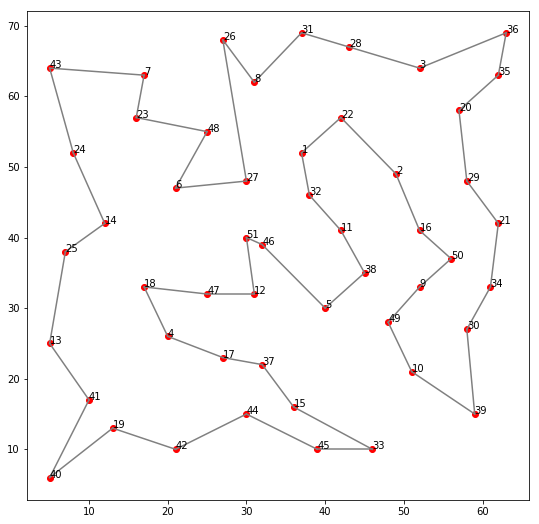

In [173]:
nodes = load_initial("eil51")[0]
annealed_tour = simulated_annealing(nodes, make_random_route(len(nodes)), 200, 500, 10, 0.985)
plotnodes(nodes)
plotedges(nodes, annealed_tour)
print(f"Length of found route: {tour_length(nodes, annealed_tour)}")